In [1]:
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sierrawulfson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
!python -m spacy download en


    Linking successful
    /Users/sierrawulfson/opt/anaconda3/envs/cs6220/lib/python3.7/site-packages/en_core_web_sm
    -->
    /Users/sierrawulfson/opt/anaconda3/envs/cs6220/lib/python3.7/site-packages/spacy/data/en

    You can now load the model via spacy.load('en')



In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
#import preprocessor as p

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
# NLTK Stop words
#from nltk.corpus import stopwords
#stop_words = stopwords.words('english')
#stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [3]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'use', 'ourselves', 'hers', 'between', 'yourself', 'but', 'again', 'there',
                   'about', 'once', 'during', 'out', 'very', 'having', 'with', 'they', 'own', 'an', 
                   'be', 'some', 'for', 'do', 'its', 'yours', 'such', 'into', 'of', 'most', 'itself',
                   'other', 'off', 'is', 's', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 'the', 
                   'themselves', 'until', 'below', 'are', 'we', 'these', 'your', 'his', 'through', 'don', 
                   'nor', 'me', 'were', 'her', 'more', 'himself', 'this', 'down', 'should', 'our', 'their',
                   'while', 'above', 'both', 'up', 'to', 'ours', 'had', 'she', 'all', 'no', 'when', 'at', 
                   'any', 'before', 'them', 'same', 'and', 'been', 'have', 'in', 'will', 'on', 'does', 
                   'yourselves', 'then', 'that', 'because', 'what', 'over', 'why', 'so', 'can', 'did', 
                   'not', 'now', 'under', 'he', 'you', 'herself', 'has', 'just', 'where', 'too', 'only',
                   'myself', 'which', 'those', 'i', 'after', 'few', 'whom', 't', 'being', 'if', 'theirs', 
                   'my', 'against', 'a', 'by', 'doing', 'it', 'how', 'further', 'was', 'here', 'than', 'th',
                   'go', 'whos', 'ive', 'etc', 'trump','fake', 'fake_new', 'fake_news', 'melania', 'hillary', 'crooked_hillary', 
                   'james_comey', 'puerto_rico', 'vote', 'crooked' ,'hillary_clinton' ,
                   'rally', 'thankyoutoour', 'fakenew', 'electoral_college', 'http', 'https' ,'amp'])

###"""'my', 'against', 'a', 'by', 'doing', 'it', 'how', 'further', 'was', 'here', 'than', 'th',
#                   'go', 'whos', 'ive', 'etc', 'fake', 'fake_new', 'fake_news', 'melania', 'hillary', 'crooked', 
#                   'james_comey', 'puerto_rico', 'hurricane', 'vote', 'crooked' ,'hillary_clinton' ,
#                    'rally', 'florida', 'nyc', 'alabama', 'ohio', 'kentucky', 'thankyoutoour', 'trump', 
#                    'fakenew', 'electoral_college','north_carolina'])"""

df = pd.read_csv("../tweets_sentiments4dla.csv", index_col=0)

# Convert to list
data = df.text.values.tolist()

## cleaning
#p.set_options(p.OPT.EMOJI, p.OPT.SMILEY)
#data = [p.clean(sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]
# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])


['A great try by . We are all proud of you!']


In [4]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['great', 'try', 'by', 'we', 'are', 'all', 'proud', 'of', 'you']]


In [5]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['great', 'try', 'by', 'we', 'are', 'all', 'proud', 'of', 'you']


In [6]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [7]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['great', 'try', 'proud']]


In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1)]]


In [12]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
#ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [11]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(9,
  [('people', 0.04693548387096774),
   ('work', 0.036774193548387096),
   ('speak', 0.029838709677419355),
   ('leave', 0.02661290322580645),
   ('florida', 0.025161290322580646),
   ('close', 0.02129032258064516),
   ('safe', 0.020161290322580645),
   ('prime_minister', 0.01935483870967742),
   ('state', 0.01467741935483871),
   ('hurricane', 0.012741935483870967)]),
 (15,
  [('people', 0.09018247624792641),
   ('democrat', 0.0830945558739255),
   ('country', 0.07811793093047806),
   ('wall', 0.05217915849796411),
   ('security', 0.0414718745287287),
   ('stop', 0.035892022319408835),
   ('build', 0.030312170110088976),
   ('include', 0.025787965616045846),
   ('southern_border', 0.0208113406725984),
   ('party', 0.020208113406725983)]),
 (11,
  [('news', 0.12718460860625644),
   ('medium', 0.06535467763254516),
   ('story', 0.042590688794242916),
   ('bad', 0.03862534880305478),
   ('report', 0.025113819944191512),
   ('watch', 0.023204582170656483),
   ('corrupt', 0.02041415773

In [13]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        model_topics = model.show_topics(formatted=False)
        pprint(model.print_topics(num_topics=num_topics, num_words=50))
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [14]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=5, limit=10, step=1)

[(0,
  '0.040*"democrat" + 0.028*"american" + 0.027*"work" + 0.019*"republican" + '
  '0.016*"border" + 0.016*"deal" + 0.015*"give" + 0.014*"wall" + '
  '0.012*"security" + 0.012*"hard" + 0.011*"dem" + 0.010*"end" + '
  '0.009*"support" + 0.009*"family" + 0.009*"include" + 0.009*"senate" + '
  '0.008*"house" + 0.008*"build" + 0.008*"national" + 0.008*"bill" + '
  '0.008*"put" + 0.007*"continue" + 0.007*"dollar" + 0.007*"tax_cut" + '
  '0.007*"law" + 0.007*"vote" + 0.006*"act" + 0.006*"order" + 0.006*"live" + '
  '0.005*"pass" + 0.005*"announce" + 0.005*"agree" + 0.005*"remember" + '
  '0.005*"drug" + 0.005*"spend" + 0.005*"iran" + 0.005*"begin" + 0.004*"part" '
  '+ 0.004*"home" + 0.004*"month" + 0.004*"major" + 0.004*"fast" + '
  '0.004*"healthcare" + 0.004*"fix" + 0.004*"office" + 0.004*"care" + '
  '0.004*"kill" + 0.004*"plan" + 0.004*"hold" + 0.004*"court"'),
 (1,
  '0.054*"president" + 0.049*"people" + 0.022*"state" + 0.016*"crime" + '
  '0.016*"strong" + 0.015*"military" + 0.013*

[(0,
  '0.037*"democrat" + 0.032*"border" + 0.026*"people" + 0.026*"republican" + '
  '0.020*"crime" + 0.020*"military" + 0.019*"country" + 0.018*"wall" + '
  '0.017*"security" + 0.015*"congress" + 0.014*"work" + 0.013*"fight" + '
  '0.013*"mexico" + 0.013*"end" + 0.013*"support" + 0.013*"stop" + '
  '0.012*"include" + 0.012*"senate" + 0.012*"house" + 0.011*"build" + '
  '0.010*"bill" + 0.009*"protect" + 0.009*"law" + 0.009*"act" + 0.009*"vote" + '
  '0.008*"sign" + 0.007*"pass" + 0.007*"southern_border" + 0.007*"tough" + '
  '0.007*"party" + 0.007*"drug" + 0.006*"reason" + 0.006*"close" + 0.006*"dem" '
  '+ 0.006*"major" + 0.006*"law_enforcement" + 0.006*"member" + 0.006*"fix" + '
  '0.006*"care" + 0.005*"kill" + 0.005*"change" + 0.005*"safety" + '
  '0.005*"attack" + 0.005*"finally" + 0.005*"send" + 0.005*"immigration" + '
  '0.005*"system" + 0.005*"policy" + 0.005*"syria" + 0.004*"dangerous"'),
 (1,
  '0.074*"president" + 0.038*"american" + 0.037*"today" + 0.025*"day" + '
  '0.018*"

[(0,
  '0.089*"people" + 0.049*"work" + 0.029*"give" + 0.022*"bad" + 0.022*"hard" + '
  '0.018*"show" + 0.013*"wonderful" + 0.012*"important" + 0.012*"true" + '
  '0.011*"friend" + 0.011*"false" + 0.011*"order" + 0.010*"include" + '
  '0.010*"man" + 0.010*"justice" + 0.010*"family" + 0.009*"terrible" + '
  '0.008*"week" + 0.007*"force" + 0.007*"kill" + 0.007*"lawyer" + '
  '0.006*"judge" + 0.006*"attack" + 0.006*"destroy" + 0.006*"smart" + '
  '0.006*"person" + 0.006*"million" + 0.006*"power" + 0.006*"sad" + '
  '0.006*"prayer" + 0.006*"thing" + 0.005*"special" + 0.005*"stay" + '
  '0.005*"agenda" + 0.005*"child" + 0.005*"federal" + 0.005*"horrible" + '
  '0.005*"chance" + 0.005*"term" + 0.004*"biden" + 0.004*"matter" + '
  '0.004*"thought" + 0.004*"fine" + 0.004*"hate" + 0.004*"hour" + '
  '0.004*"voter" + 0.004*"effort" + 0.004*"choice" + 0.004*"department" + '
  '0.004*"anti"'),
 (1,
  '0.055*"news" + 0.028*"medium" + 0.021*"russia" + 0.020*"collusion" + '
  '0.018*"fbi" + 0.018*"st

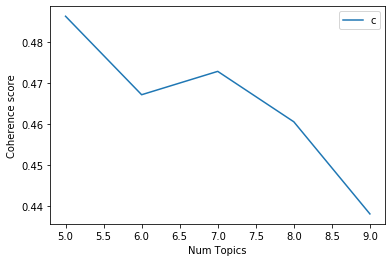

In [15]:
# Show graph
limit=10; start=5; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [16]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 5  has Coherence Value of 0.4863
Num Topics = 6  has Coherence Value of 0.4671
Num Topics = 7  has Coherence Value of 0.4728
Num Topics = 8  has Coherence Value of 0.4605
Num Topics = 9  has Coherence Value of 0.438


In [17]:
# Select the model and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=50))

[(0,
  '0.037*"democrat" + 0.032*"border" + 0.026*"people" + 0.026*"republican" + '
  '0.020*"crime" + 0.020*"military" + 0.019*"country" + 0.018*"wall" + '
  '0.017*"security" + 0.015*"congress" + 0.014*"work" + 0.013*"fight" + '
  '0.013*"mexico" + 0.013*"end" + 0.013*"support" + 0.013*"stop" + '
  '0.012*"include" + 0.012*"senate" + 0.012*"house" + 0.011*"build" + '
  '0.010*"bill" + 0.009*"protect" + 0.009*"law" + 0.009*"act" + 0.009*"vote" + '
  '0.008*"sign" + 0.007*"pass" + 0.007*"southern_border" + 0.007*"tough" + '
  '0.007*"party" + 0.007*"drug" + 0.006*"reason" + 0.006*"close" + 0.006*"dem" '
  '+ 0.006*"major" + 0.006*"law_enforcement" + 0.006*"member" + 0.006*"fix" + '
  '0.006*"care" + 0.005*"kill" + 0.005*"change" + 0.005*"safety" + '
  '0.005*"attack" + 0.005*"finally" + 0.005*"send" + 0.005*"immigration" + '
  '0.005*"system" + 0.005*"policy" + 0.005*"syria" + 0.004*"dangerous"'),
 (1,
  '0.074*"president" + 0.038*"american" + 0.037*"today" + 0.025*"day" + '
  '0.018*"

In [18]:
#find dominant topic in each sentence
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(20)




,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5.0,0.1758,"great, big, state, win, america, love, congrat...",A great try by . We are all proud of you!
1,1,5.0,0.1927,"great, big, state, win, america, love, congrat...",Vote for Sean Spicer on Dancing with the Stars...
2,2,4.0,0.2048,"news, people, bad, medium, call, thing, story,...",“This isn’t about Ukraine. This isn’t about Im...
3,3,6.0,0.1725,"democrat, give, russia, collusion, dem, fbi, w...",want that to be an impeachable offense? Good l...
4,4,2.0,0.1812,"good, year, job, time, election, strong, high,...",“The President has until September 30th to giv...
5,5,6.0,0.1820,"democrat, give, russia, collusion, dem, fbi, w...",Schiff and the Dems have created this whole th...
6,6,1.0,0.1585,"president, american, today, day, world, honor,...",In order to continue being the most Transparen...
7,7,4.0,0.1990,"news, people, bad, medium, call, thing, story,...",Just like Schiff fabricated my phone call he w...
8,8,6.0,0.1869,"democrat, give, russia, collusion, dem, fbi, w...",Schiff is giving Republicans NO WITNESSES NO L...
9,9,4.0,0.1914,"news, people, bad, medium, call, thing, story,...",Read the Transcript. It is PERFECT!


In [26]:
data = pd.read_csv("../tweets_sentiments2.csv")
data[['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']]=\
    df_dominant_topic[['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']]
print(data.columns)
data = data[['id_str', 'text', 'created_at', 'retweet_count', 'favorite_count',
       'is_retweet', 'neg', 'neu', 'pos', 'cmpd', 'date', 'time',
       'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords']]
data.to_csv('tweets_sents_lda.csv')


Index(['id_str', 'text', 'created_at', 'retweet_count', 'favorite_count',
       'is_retweet', 'neg', 'neu', 'pos', 'cmpd', 'date', 'time',
       'Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords',
       'Text'],
      dtype='object')


In [26]:
#find representative topics
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.3386,"great, america, republican, win, state, make, ...",Congratulations to Bryan Steil on a wonderful ...
1,1.0,0.3754,"country, make, china, deal, united_state, pay,...",China is subsidizing its product in order that...
2,2.0,0.3417,"news, bad, people, medium, time, call, story, ...",Another false story this time in the Failing t...
3,3.0,0.3353,"people, border, country, crime, strong, milita...",If we don’t have a wall system we’re not going...
4,4.0,0.3698,"democrat, election, give, russia, collusion, d...",“Conflict between Glen Simpson’s testimony to ...
5,5.0,0.3576,"president, american, today, day, world, honor,...",The citizens of Venezuela have suffered for to...
6,6.0,0.3663,"big, good, job, work, year, president, back, t...",On Taxes: “This is the biggest corporate rate ...


In [28]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"great, america, republican, win, state, make, ...",2063.0,0.1756
1.0,0.0,"great, america, republican, win, state, make, ...",1502.0,0.1279
2.0,2.0,"news, bad, people, medium, time, call, story, ...",1799.0,0.1532
3.0,2.0,"news, bad, people, medium, time, call, story, ...",1567.0,0.1334
4.0,1.0,"country, make, china, deal, united_state, pay,...",1697.0,0.1445
...,...,...,...,...
11740.0,0.0,"great, america, republican, win, state, make, ...",NaN,NaN
11741.0,5.0,"president, american, today, day, world, honor,...",NaN,NaN
11742.0,5.0,"president, american, today, day, world, honor,...",NaN,NaN
11743.0,5.0,"president, american, today, day, world, honor,...",NaN,NaN
